In [1]:
import sys
sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

In [2]:
import sys
sys.path.insert(0, '/home/563/esh563/TINT')

In [3]:
# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import classification as cl
import two_dimensional_analysis as td
import caine_func as caf
import analysis

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport classification
%aimport two_dimensional_analysis
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF

%pdb


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.int, "int"), (np.int8, "int"),
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/gexf.py:220: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to us

Automatic pdb calling has been turned ON


In [4]:
base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

In [5]:
base_dir = '/g/data/hj10/cpol/cpol_level_1b/v2020/gridded/grid_150km_2500m/'
save_dir = '/home/563/esh563/TINT_tracks/'
fig_dir = '/home/563/esh563/TINT_figures/'
ERA5_dir = '/g/data/rt52/era5/pressure-levels/reanalysis/'

In [6]:
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'mathtext.fontset': 'dejavuserif'})
rcParams.update({'font.size': 12})

In [7]:
class_thresh = {
    'OFFSET_MAG': 10000,  # metres
    'SHEAR_MAG': 2,  # m/s
    'VEL_MAG': 5,  # m/s
    'REL_VEL_MAG': 2,  # m/s
    'ANGLE_BUFFER': 10}

excl_thresh = {
    'SMALL_AREA': 500,  # km^2
    'LARGE_AREA': 50000,  # km^2
    'BORD_THRESH': 0.001,  # Ratio border pixels to total pixels
    'MAJOR_AXIS_LENGTH': 25,  # km
    'AXIS_RATIO': 2,
    'DURATION': 30}

all_dic, FFTS_UST_dic, TS_dic, LS_dic = td.shear_versus_orientation(class_thresh, excl_thresh)

Getting data for year 1998.
Recalculating Exclusions
Calculating system tracks.
Getting data for year 1999.
Recalculating Exclusions
Calculating system tracks.
Getting data for year 2001.
Recalculating Exclusions
Calculating system tracks.
Getting data for year 2002.
Recalculating Exclusions
Calculating system tracks.
Getting data for year 2003.
Recalculating Exclusions
Calculating system tracks.
Getting data for year 2004.
Recalculating Exclusions
Calculating system tracks.
Getting data for year 2005.
Recalculating Exclusions
Calculating system tracks.
Getting data for year 2006.
Recalculating Exclusions
Calculating system tracks.
Getting data for year 2009.
Recalculating Exclusions
Calculating system tracks.
Getting data for year 2010.
Recalculating Exclusions
Calculating system tracks.
Getting data for year 2011.
Recalculating Exclusions
Calculating system tracks.
Getting data for year 2012.
Recalculating Exclusions
Calculating system tracks.
Getting data for year 2013.
Recalculatin

In [8]:
len(all_dic['shear_angle_list'])

7361

In [19]:
first_five

[0.43716886292623286,
 0.6297327394209353,
 0.5238991343620625,
 0.3071297989031078]

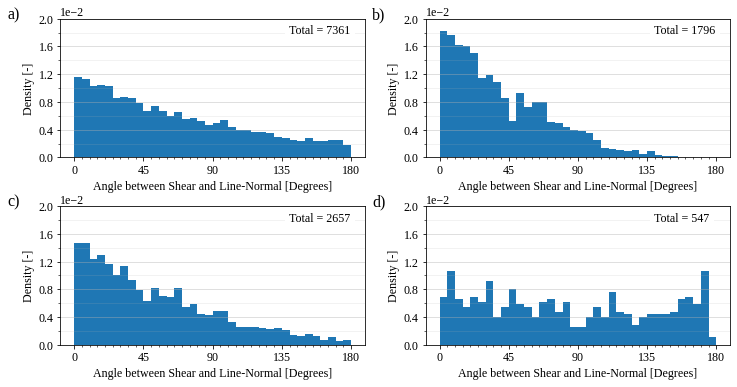

In [17]:
first_five = td.shear_angle_versus_orientation_hist([all_dic, FFTS_UST_dic, TS_dic, LS_dic], data='base')

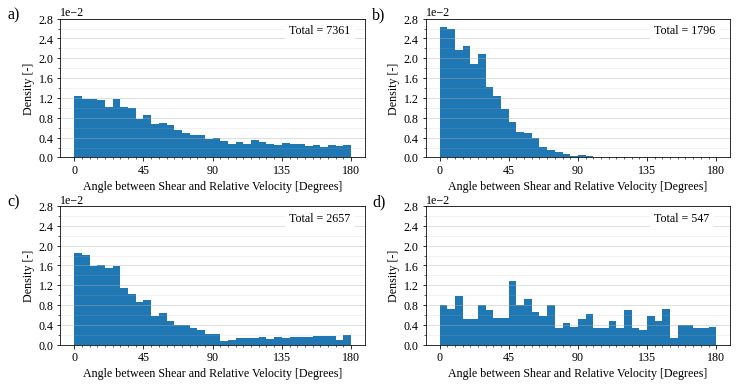

In [20]:
first_nine = td.shear_angle_versus_propagation_hist([all_dic, FFTS_UST_dic, TS_dic, LS_dic], data='base')

In [21]:
first_nine

[0.486482814834941, 0.8613585746102449, 0.6522393677079413, 0.3071297989031078]

([<matplotlib.axis.YTick at 0x7f99e6817ca0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

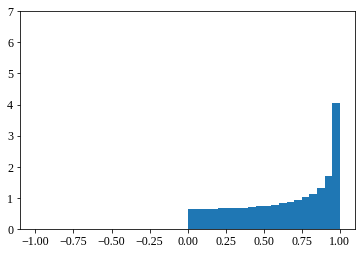

In [152]:
x = np.random.uniform(low=0, high=np.pi*2, size=1000000)
y = np.random.uniform(low=0, high=np.pi*2, size=1000000)

result = np.cos(np.mod(x-y+np.pi/2, np.pi) - np.pi/2)

# result = np.cos(x-y)
db = 0.05
bins = np.arange(-1, 1+db, db)
# plt.set_yticks(np.arange(0, 8, 1))
# plt.set_yticks(np.arange(0, 8, .5), minor=True)

plt.hist(result, bins=bins, density=True)
plt.yticks(np.arange(0, 8, 1))